# Burn scar mapping on Sentinel 2 Near Real Time data

* __Compatability:__ Notebook currently only compatible with DEA Sandbox environment as near real time data is not avaible on the NCI
* **Products used:** 
[s2a_nrt_granule](https://explorer.sandbox.dea.ga.gov.au/s2a_nrt_granule), 
[s2b_nrt_granule](https://explorer.sandbox.dea.ga.gov.au/s2b_nrt_granule),
[s2a_ard_granule](https://explorer.sandbox.dea.ga.gov.au/s2a_ard_granule), 
[s2b_ard_granule](https://explorer.sandbox.dea.ga.gov.au/s2b_ard_granule),

## Description

This notebook calculates the change in Normalized Burn Ratio between a baseline composite image of the pre-fire condition of a selected area and a post-fire event image, in order to find burn scar extent. 
 
The user can change the location over which this notebook is run and specify a different date between which pre and post fire condition will be compared. The length of time over which the baseline composite image will be generated can be specified as 3, 6 or 12 months. The code in this notebook will automatically generate the composite image over the set length of time using both Sentinel 2 Near Real Time data and the definitive Sentinel 2 Analysis Ready Product.

__This notebook has been designed for mapping fire extent in recent fires, and so assumes that NRT products will need to be used. If the area fire of interest is historical, users should select the definitive Sentinel 2 Analysis Ready Product instead.__

### The notebook contains the following steps:
1.  Load Packages
2.  Select location
3.  Define fire event date and length of composite image
4.  Load all baseline data
5.  Generate Normalized Burn Ratio for baseline period
6.  Load post-fire data from Near Real Time data
7.  Generate Normalized Burn Ratio for post fire image
8.  Caculate Delta Normalized Burn Ratio
9.  Apply threshold to Delta Normalized Burn Ratio
10. Calculate the area burnt
11. Save results as Geotiff


## Background

### Normalized Burn Ratio

The Normalized Burn Ratio (NBR) is an index that uses the differences in the way health green vegetation and burned vegetation reflect light to find burned area. It is calculated using the following Sentinel 2 bands; Near Infrared/Band 8 and Shortwave Infrared/Band 12. The equation is defined below: 

\begin{equation}
NBR = \frac{(NIR - SWIR)}{(NIR + SWIR)}
\end{equation}

NBR returns values between -1 and 1. __Healthy green vegetation will have a high NBR value while burned vegetation will have a low value__. Areas of dry brown vegetation or bare soil will also return lower NBR values than green vegetation. 

### Delta Normalized Burn Ratio

Change in Normalized Burn Ration, also called Delta Normalized Burn Ration (dNBR) is calculated by subtracting the post fire NBR value from the baseline NBR value as defined in this equation:

\begin{equation}
dNBR = NBR_{baseline} - NBR_{post fire}
\end{equation}

The dNBR value can be more useful than the NBR alone to determine what has burned as it shows change from the baseline sate. __A burned area will have a positive dNBR value__ while an unburned area will have a negative dNBR value or a value close to zero.

dNBR can also be used to describe burn severity (although this notebook does not look at burn severity) the principal of this is that a higher severity fire will burn more vegetation, resulting in a higher dNBR. More information on NBR, dNBR and using it to measure burn severity can be found [on the UN-SPIDER knowledge portal](http://un-spider.org/advisory-support/recommended-practices/recommended-practice-burn-severity/in-detail/normalized-burn-ratio).

### Defining Burned From Unburned Areas

[Rahman et al. 2018](https://doi.org/10.1109/IGARSS.2018.8518449) found a dNBR threshold value of +0.1 appropriate for differentiating burned from un burned areas when using Sentinel 2. However, some exploration with different threshold levels may be needed to get a good result in areas with different vegetation types. 

In the example presented in this notebook, which covers part of the Clyde Mountain fire in the area north of Batemans Bay the fire occurred in heavily forested area, which returns a very strong dNBR result. Using +0.1 as a threshold here results in a lot of false positives being picked un in the unburned urban and forest areas where vegetation drying has occurred prior to the fire. A much more conservative threshold here of +0.3 produces a better result. Keep in mind the limitations of remote sensing and that in an ideal situation ground truth data collected in the location of interest would be used to assist in selecting a threshold.

Some care should also be taken when interoperating results as a number of possible false positives can return a positive dNBR result:
* A lot of smoke in the post burn image can interfere with the dNBR value
* Areas that have been cleared of vegetation by some other means (logging, harvesting, and landslides) towards the end of the baseline period may incorrectly show up as burned
* Drying out bright green vegetation such as grasses. If a fire event has been preceded by a rapid drying out of vegetation this can result in a low positive dNBR value in areas that have not burned.


## Load packages
Import Python packages that are used for the analysis.

In [2]:
import sys
import datacube
from datacube.helpers import write_geotiff
from datetime import datetime
from datetime import timedelta
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("../Scripts")
from dea_datahandling import load_ard
from dea_plotting import rgb
from dea_plotting import display_map
import dea_bandindices

In [3]:
dc = datacube.Datacube(app="Sentinel_2_burn_ratio")

## Select Location

The selected latitude and longitude will be displayed as a red box on the map below the next cell. This map can be used to find coordinates of other places, simply scroll and click on any point on the map to display the latitude and longitude of that location.

In [4]:
# Set the central latitude and longitude
central_lat = -35.653031
central_lon = 150.231667

# Set the buffer to load around the central coordinates
buffer = 0.1

# Compute the bounding box for the study area
study_area_lat = (central_lat - buffer, central_lat + buffer)
study_area_lon = (central_lon - buffer, central_lon + buffer)

display_map(x=study_area_lon, y=study_area_lat, margin=-0.2)

/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


## Define fire event date and length of composite image

Delta Normalized Burn Ratio produces the best result when using a post-fire image that was collected before much re-growth has occured. However images collected while the fire is still active can be obsured by smoke and not show the full burn extent. As a result some adjustment of the fire event date entered may be needed to get the best restult.

In [5]:
# Fire event date
fire_date = '2020-01-05'

# Length of Baseline Period
baseline_length = '3 months' # Can be 3, 6 or 12 months


#### Automaticaly define date range for baseline composite image

In [6]:
# Define dates for loading data
if baseline_length == '12 months':
    time_step = timedelta(days=365)
if baseline_length == '6 months':
    time_step = timedelta(days=182.5)
if baseline_length == '3 months':
    time_step = timedelta(days=91)

# Calculate the start and end date for baseline data load
start_date_pre = datetime.strftime(((datetime.strptime(fire_date, '%Y-%m-%d'))-time_step), '%Y-%m-%d')
end_date_pre = datetime.strftime(((datetime.strptime(fire_date, '%Y-%m-%d'))-timedelta(days=1)), '%Y-%m-%d')

# Calculate end date for post fire data load
start_date_post = datetime.strftime(((datetime.strptime(fire_date, '%Y-%m-%d'))+timedelta(days=1)), '%Y-%m-%d')
end_date_post = datetime.strftime(((datetime.strptime(fire_date, '%Y-%m-%d'))+timedelta(days=30)), '%Y-%m-%d')

In [7]:
# Print dates
print('start_date_pre:  '+start_date_pre)
print('end_date_pre:    '+end_date_pre) # if end date is exclusive, just use fire_date
print('fire_date:       '+fire_date)
print('start_date_post: '+start_date_post)
print('end_date_post:   '+end_date_post)


start_date_pre:  2019-10-06
end_date_pre:    2020-01-04
fire_date:       2020-01-05
start_date_post: 2020-01-06
end_date_post:   2020-02-04


## Load all baseline data

#### Load all avaliable ARD baseline data

In [8]:
resolution=(-10, 10)

# Load all data in basline period avalible from ARD data
ard_baseline_da = load_ard(dc=dc,
              products=['s2a_ard_granule', 's2b_ard_granule'],#,],'s2a_nrt_granule', 's2b_nrt_granule'
              x=study_area_lon,
              y=study_area_lat,
              time=(start_date_pre, end_date_pre),
              measurements=['nbart_blue','nbart_green','nbart_red','nbart_nir_1', 'nbart_swir_3'],
              min_gooddata=0.5,
              output_crs='EPSG:3577',
              resolution=resolution,
#               dask_bs = {'x': 500, 'y': 500},
              group_by='solar_day')
ard_baseline_da

Loading s2a_ard_granule data
    Filtering to 4 out of 6 observations
    Applying pixel quality/cloud mask
    Applying invalid data mask
    Applying contiguity mask
Loading s2b_ard_granule data
    Filtering to 1 out of 3 observations
    Applying pixel quality/cloud mask
    Applying invalid data mask
    Applying contiguity mask
Combining and sorting data
    Returning 5 observations 


<xarray.Dataset>
Dimensions:       (time: 5, x: 2108, y: 2457)
Coordinates:
  * y             (y) float64 -4e+06 -4e+06 -4e+06 ... -4.024e+06 -4.024e+06
  * x             (x) float64 1.633e+06 1.633e+06 ... 1.654e+06 1.654e+06
  * time          (time) datetime64[ns] 2019-10-17T00:02:39.024000 ... 2019-12-01T00:02:41.024000
Data variables:
    nbart_blue    (time, y, x) float32 188.0 129.0 176.0 213.0 ... nan nan nan
    nbart_green   (time, y, x) float32 253.0 172.0 215.0 294.0 ... nan nan nan
    nbart_red     (time, y, x) float32 192.0 123.0 178.0 234.0 ... nan nan nan
    nbart_nir_1   (time, y, x) float32 2168.0 1716.0 2058.0 ... nan nan nan
    nbart_swir_3  (time, y, x) float32 398.0 355.0 355.0 423.0 ... nan nan nan
Attributes:
    crs:      EPSG:3577

In [9]:
# Find the earliest date from which an observation has been returned from near real time data
last_ard_date = (pd.to_datetime((ard_baseline_da.time[-1]).values)).strftime('%Y-%m-%d')
last_ard_date

'2019-12-01'

#### Load any NRT to fill in the gap between ARD and fire date

In [10]:
# Load remaining data in basline period avalible from Analysis Ready Data collection (definative sentinel collection)
nrt_baseline_da = load_ard(dc=dc,
              products=['s2a_nrt_granule', 's2b_nrt_granule'],
              x=study_area_lon,
              y=study_area_lat,
              time=(last_ard_date,end_date_pre),
              measurements=['nbart_blue','nbart_green','nbart_red','nbart_nir_1', 'nbart_swir_3'],
              min_gooddata=0.5,
              output_crs='EPSG:3577',
              resolution=(-10, 10),
#               dask_chunks = {'x': 500, 'y': 500},
              group_by='solar_day')


Loading s2a_nrt_granule data
    Filtering to 1 out of 4 observations
    Applying pixel quality/cloud mask
    Applying invalid data mask
    Applying contiguity mask
Loading s2b_nrt_granule data
    Filtering to 1 out of 3 observations
    Applying pixel quality/cloud mask
    Applying invalid data mask
    Applying contiguity mask
Combining and sorting data
    Returning 2 observations 


In [11]:
# Check for overlaps 
ard_dates = (pd.to_datetime((ard_baseline_da.time).values)).strftime('%Y-%m-%d')
nrt_dates = (pd.to_datetime((nrt_baseline_da.time).values)).strftime('%Y-%m-%d') #[1:]
print('ard dates')
print(ard_dates)
print('nrt dates')
print(nrt_dates)

ard dates
Index(['2019-10-17', '2019-10-22', '2019-11-01', '2019-11-21', '2019-12-01'], dtype='object')
nrt dates
Index(['2019-12-01', '2019-12-26'], dtype='object')


#### Remove NRT if ARD is avaliable

In [12]:
# Remove milliseconds 
ard_baseline_da['time'] = ard_baseline_da.indexes['time'].normalize()
nrt_baseline_da['time'] = nrt_baseline_da.indexes['time'].normalize()

# Find duplicates
duplicate_dates = nrt_baseline_da['time'].isin(ard_baseline_da['time'].values)

# Only select NRT that is not duplicated in ARD
nrt_baseline_da = nrt_baseline_da.sel(time=~duplicate_dates)

#### Join all baseline data into one dataset

Data loaded fron Near Real Time product and Analysis Ready Data will be joined into one dataste in order to generate composite image. Make sure there are no overlaps.

In [13]:
# Concantenate NRT and ARD data together 
combined_baseline = xr.concat([ard_baseline_da,nrt_baseline_da], dim='time').sortby('time')

In [14]:
dates = (pd.to_datetime((combined_baseline.time).values)).strftime('%Y-%m-%d')
dates

Index(['2019-10-17', '2019-10-22', '2019-11-01', '2019-11-21', '2019-12-01',
       '2019-12-26'],
      dtype='object')

## Generate Normalized Burn Ratio for baseline period

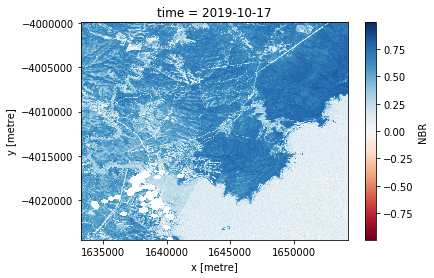

In [15]:
# Calculate NBR for the baseline images
combined_baseline = dea_bandindices.calculate_indices(combined_baseline,index='NBR',collection='ga_s2_1')

# Plot the results for one time step to see what they look like:
combined_baseline.NBR.isel(time=0).plot(cmap='RdBu')

#### Generate composite image from baseline data

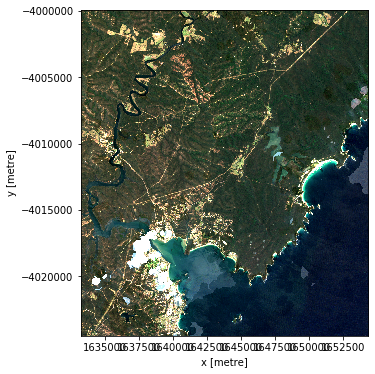

In [16]:
# Compute median using all observations in the dataset along the time axis
regmedian = combined_baseline.median(dim='time')

# Visualise baseline image as  true colour image
rgb(regmedian, bands=['nbart_red', 'nbart_green', 'nbart_blue'])

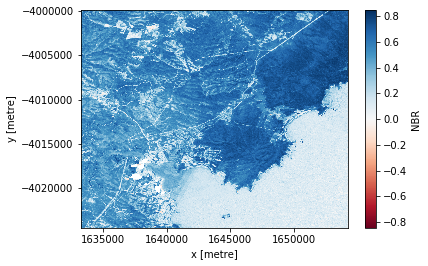

In [17]:
# Finally create baseline NBR image
baseline_NBR = regmedian.NBR

# Visualise nbr baseline image
baseline_NBR.plot(cmap='RdBu')

## Load post-fire data from Near Real Time data
Or if studying a historical fire, use the definetive Sentinel 2 ARD products: 's2a_ard_granule', 's2b_ard_granule'

In [18]:
# Load post-fire NRT data from Sentinel 2A and 2B
post_col = load_ard(dc=dc,
              products=['s2a_nrt_granule', 's2b_nrt_granule'],
              x=study_area_lon,
              y=study_area_lat,
              time=(start_date_post, end_date_post),
              min_gooddata=0.6,
              measurements=['nbart_blue','nbart_green','nbart_red','nbart_nir_1', 'nbart_swir_3'],
              output_crs='EPSG:3577',
              resolution=(-10, 10),
              group_by='solar_day')

Loading s2a_nrt_granule data
    Filtering to 2 out of 3 observations
    Applying pixel quality/cloud mask
    Applying invalid data mask
    Applying contiguity mask
Loading s2b_nrt_granule data
    Filtering to 1 out of 3 observations
    Applying pixel quality/cloud mask
    Applying invalid data mask
    Applying contiguity mask
Combining and sorting data
    Returning 3 observations 


#### Post-fire image

Decide whether to use 1 date or a median of post-fire dates to avoid holes

In [19]:
# Select the most recent image after the fire
#post_da = post_col.isel(time=0)

# or
post_da = post_col.median(dim='time')


print(post_da)

<xarray.Dataset>
Dimensions:       (x: 2108, y: 2457)
Coordinates:
  * y             (y) float64 -4e+06 -4e+06 -4e+06 ... -4.024e+06 -4.024e+06
  * x             (x) float64 1.633e+06 1.633e+06 ... 1.654e+06 1.654e+06
Data variables:
    nbart_blue    (y, x) float32 498.0 475.0 502.0 518.0 ... 664.5 651.5 666.0
    nbart_green   (y, x) float32 524.0 481.0 522.0 559.0 ... 558.0 571.5 540.0
    nbart_red     (y, x) float32 626.0 629.0 655.0 649.0 ... 486.0 498.0 449.5
    nbart_nir_1   (y, x) float32 1086.0 1105.0 1342.0 ... 511.0 485.5 476.5
    nbart_swir_3  (y, x) float32 1264.0 1092.0 1092.0 ... 333.0 311.5 311.5


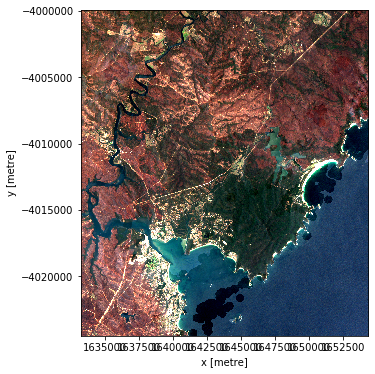

In [20]:
# Visualise post-fire image as  true colour image
rgb(post_da, bands=['nbart_red', 'nbart_green', 'nbart_blue'])

## Generate Normalized Burn Ratio for post-fire image

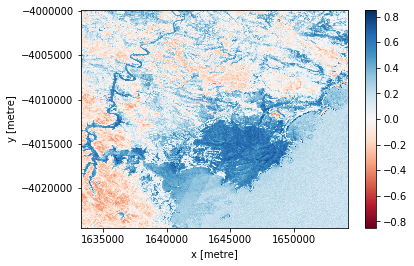

In [21]:
# Calculate nbr
post_NBR = (post_da.nbart_nir_1 - post_da.nbart_swir_3)/(post_da.nbart_nir_1 + post_da.nbart_swir_3)

# Visualise post-fire image as  NBR image
post_NBR.plot(cmap='RdBu')

## Calculate Delta Normalized Burn Ratio

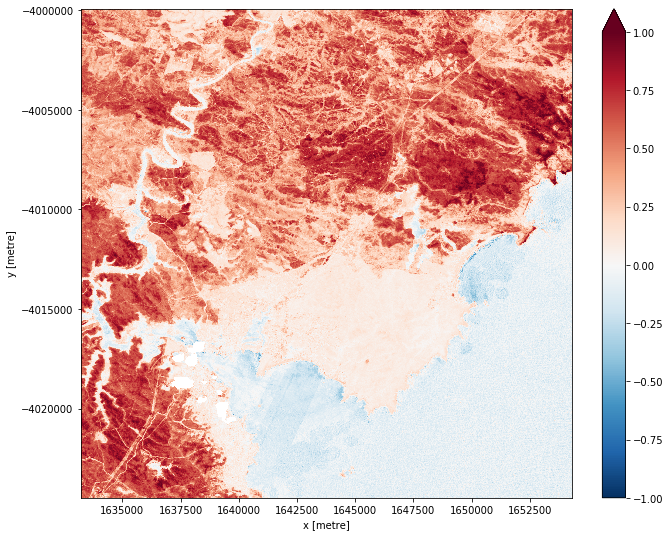

In [22]:
delta_NBR = baseline_NBR - post_NBR

delta_NBR.plot(cmap='RdBu_r', vmin=-1, vmax=1, figsize=(11,9)) 
# vmin sets the value to be displayed as the lowest value on the colour scale. When set to 0 only positive dNBR values 
# are visualised effectivly, any negative values are indistinquishable from 0.
#This can be adjusted to better visualise the value range presant if necessary

## Apply threshold to Delta Normalized Burn Ratio
The threshold will most likely need adjustment for local conditions

In [23]:
# Set threshold
threshold = 0.3

# Apply threshold
burnt = delta_NBR>threshold

# Mask post-fire true colour image
masked = delta_NBR.where(burnt==1)

Re-visualize pre and post-fire true colour images to help adjust threshold

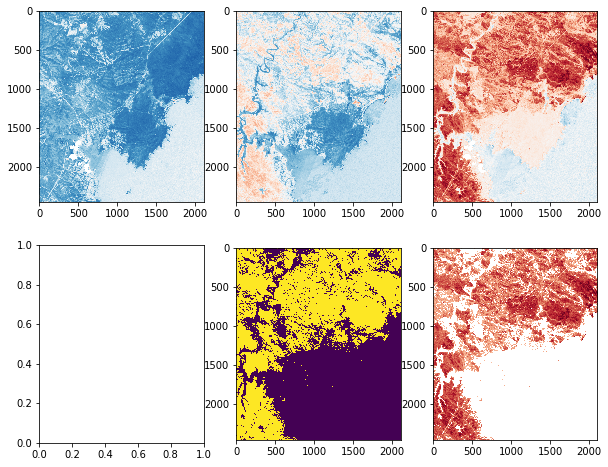

In [24]:
bands=['nbart_red', 'nbart_green', 'nbart_blue']

f, axarr = plt.subplots(2,3,figsize=(10,8),squeeze=False)
axarr[0,0].imshow(baseline_NBR,cmap='RdBu',vmin=-1, vmax=1,)#.set_title('post-fire')
axarr[0,1].imshow(post_NBR,cmap='RdBu',vmin=-1, vmax=1,)#.set_title('pre-fire')
axarr[1,1].imshow(burnt)#.set_title('burnt')
axarr[1,2].imshow(masked,cmap='RdBu_r',vmin=-1, vmax=1,)#.set_title('masked')
axarr[0,2].imshow(delta_NBR,cmap='RdBu_r',vmin=-1, vmax=1,)#.set_title('masked')


## Calculate area burnt

In [25]:
# Constants for calculating burnt area
pixel_length = resolution[1] # in metres
#print(pixel_length)
m_per_km = 1000 # conversion from metres to kilometres

# Area per pixel
area_per_pixel = pixel_length**2/m_per_km**2
#print(area_per_pixel)

# Calculate areas
unburnt_area = np.sum(delta_NBR.values<=threshold)*area_per_pixel
burnt_area = np.sum(burnt.values)*area_per_pixel
not_nan_area = np.count_nonzero(~np.isnan(delta_NBR))*area_per_pixel
nan_area = np.count_nonzero(np.isnan(delta_NBR))*area_per_pixel
total_area = unburnt_area + burnt_area + nan_area

print('Unburnt area:            ', unburnt_area)
print('Burnt area:              ', burnt_area)
print('Nan area:                ', nan_area)
print('Total area (no nans):    ', not_nan_area)
print('Total area (with nans):  ', total_area)


Unburnt area:             273.0802
Burnt area:               242.5026
Nan area:                 2.3528000000000002
Total area (no nans):     515.5828
Total area (with nans):   517.9356


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less_equal
  # This is added back by InteractiveShellApp.init_path()


## Save results to Geotiff

To save results to geotiff for use and analysis in GIS software packages un comment the following __Write_geotiff__ comands. The baseline refference image and the post fire image will both be saved as a multiband geotiff with the following bands in the following order: Blue, Green, Red, NIR, SWIR. 

The threholded burn area image will be saved as a single band image, where a value of 1 = burned and a value of 0 = not burned.

In [26]:
# Define an area name to be used in saved file names
area_name = 'Example_'

In [27]:
# Write baseline reference image to multi-band GeoTIFF
write_geotiff(area_name+'baseline_image.tif', regmedian)

# Write post fire image to multi-band GeoTIFF
write_geotiff(area_name+'post_fire_image.tif', post_da )

# Turn delta NBR into a Xarray Dataset for export to geotiff
dnbr_dataset = delta_NBR.to_dataset(name='burn_area')
write_geotiff(area_name+'burned_area.tif', dnbr_dataset)

In [28]:
post_da

<xarray.Dataset>
Dimensions:       (x: 2108, y: 2457)
Coordinates:
  * y             (y) float64 -4e+06 -4e+06 -4e+06 ... -4.024e+06 -4.024e+06
  * x             (x) float64 1.633e+06 1.633e+06 ... 1.654e+06 1.654e+06
Data variables:
    nbart_blue    (y, x) float32 498.0 475.0 502.0 518.0 ... 664.5 651.5 666.0
    nbart_green   (y, x) float32 524.0 481.0 522.0 559.0 ... 558.0 571.5 540.0
    nbart_red     (y, x) float32 626.0 629.0 655.0 649.0 ... 486.0 498.0 449.5
    nbart_nir_1   (y, x) float32 1086.0 1105.0 1342.0 ... 511.0 485.5 476.5
    nbart_swir_3  (y, x) float32 1264.0 1092.0 1092.0 ... 333.0 311.5 311.5